## Building Detection via Mask-R CNN and Spacenet V2 Data

This notebook is based on the train_shapes ipynb instructional file available on Matterport's Mask R-CNN [Github Repository](https://github.com/matterport/Mask_RCNN/blob/master/samples/shapes/train_shapes.ipynb).  The model in use has been made compatible for use with Tensorflow 2.0+ versions by Adam Kelly ([github repository](https://github.com/akTwelve/Mask_RCNN))

The Training Data for Kartoum (downloaded from [Radiant MLHub](https://mlhub.earth/data/spacenet2)) contains 1686 aerial images and associated masks covering buildings.
Images and masks have been preprocessed in 04_Training_Data

In [42]:
# Drive Working Directory
from google.colab import drive
drive.mount('/content/drive/')

import os
!ls drive/MyDrive/house_finder/
os.path.abspath('./drive/MyDrive/house_finder/Mask_RCNN/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Mask_RCNN  spacenetv2_khartoum


'/content/drive/MyDrive/house_finder/Mask_RCNN'

In [43]:
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import skimage.io
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

%matplotlib inline

In [44]:
# Root directory of the project
ROOT_DIR = os.path.abspath("./drive/MyDrive/house_finder/Mask_RCNN/")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs/")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [45]:
os.path.join(ROOT_DIR, 'logs')

'/content/drive/MyDrive/house_finder/Mask_RCNN/logs'

Configurations for Spacenet Data

In [46]:
class SpaceNetConfig(Config):
  """
  Configuration for training on Spacenet V2 Data.
  Derives from the base Config Class and overrides values specific to the use case.
  """
  NAME = "SpaceNet"
  BACKBONE = "resnet50"
  # Train on 1 GPU and 8 images per GPU.  Images here are reasonably small
  GPU_COUNT = 1
  IMAGES_PER_GPU = 8

  # Number of Classes (including background)
  NUM_CLASSES = 1 + 1
  """
  NOTE: In an ideal workflow, multiple classes of buildings would be available for
  detailed building categorization by roof profile.  Here the number of classes would be:
  1 (background)
    + (n_roof colors (ex. red, black, gray, silver, yellow)
      *
      (m_roof profiles (ex. flat, single peak, T, hip-val, etc.))
  """

  # Use Small images for fater training, set limits on image size
  IMAGE_MIN_DIM = 640
  IMAGE_MAX_DIM = 640

  # Use smaller anchors because our image and objects are small
  RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
  RPN_ANCHOR_RATIOS = (0.25, 1, 4)

  # Reduce training ROIs per image because the images are small and have
  # few objects.  Aim to allow ROI sampling to pick 33% positive ROIs
  TRAIN_ROIS_PER_IMAGE = 32

  USE_MINI_MASK = True

  # Use a moderately sized epoch as our data is moderately complex.
  STEPS_PER_EPOCH = 500

  #Scale validation steps for the epoch size
  VALIDATION_STEPS = 50

  MAX_GT_INSTANCES = 250
  DETECTION_MAX_INSTANCES = 350

config = SpaceNetConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        350
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  640
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  640
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [640 640   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

Notebook Preferences

In [47]:
def get_ax(rows = 1, cols = 1, size = 8):
  _, ax = plt.subplots(rows, cols, figsize = (size * cols, size * rows))
  return ax

def fill_between(polygon):
  ## returns a boolean array filling in the set polygon
  img = Image.new('1', (650, 650), False)
  ImageDraw.Draw(img).polygon(polygon, outline = True, fill = True)
  mask = np.array(img)
  return mask

Dataset

In [48]:
# !ls ./drive/MyDrive/house_finder/spacenetv2_khartoum/images/

In [63]:
# training data hosted in drive
data_dir = './drive/MyDrive/house_finder/spacenetv2_khartoum/'
#if run locally
# training_dir = '.../data/training_data/spacenetv2/'

class SpaceNetDataset(utils.Dataset):

  def load_dataset(self, dataset_dir, start = 1, end = 1000):
    self.add_class("SpaceNetDataset", 1, "building")

    #locate the files for training.
    # Here files have been converted from .tif and .geojson to .png
    images_dir = os.path.join(data_dir, 'images/')
    annotations_dir = os.path.join(data_dir, 'maps/')

    #Iterate through the files in the folder to add class, images, annotations
    for filename in os.listdir(images_dir)[start:end]:
      image_id = filename[3:-11] #ex. img1017PS-RGB_.png
                                     #012    yx987654321
      image_dir = os.path.join(images_dir, str(filename))
      ann_path = os.path.join(annotations_dir, str(image_id)+"mask.png") #ex. 1017label_.png
      self.add_image('SpaceNetDataset' , image_id = image_id, path=image_dir, annotation = ann_path)

  def load_image(self, image_id):
    image_dir = os.path.join(data_dir, 'images/', 'img'+str(image_id)+'PS-RGB_.png')
    im = Image.open(image_dir)
    return np.asarray(im)

  def image_reference(self, image_id):
    info = self.image_info[image_id]
    if info['source'] == 'shapes':
      return info['shapes']
    else:
      super(self.__class__).image_reference(self, image_id)

  def load_mask(self, image_id):
    mask_path = os.path.join(data_dir, 'maps', str(image_id)+'mask_.png')
    mask_img = cv2.imread(mask_path, 0)

    if mask_img.shape != (650,650):
      masks = mask_img[:,:,1:]
      class_ids = np.asarray([1] * masks.shape[2])
    else:
      class_ids = np.ones((1))
      masks = mask_img.reshape((650,650,1))

    mask_arr = np.array(masks)
    return mask_arr.astype(np.bool), class_ids.astype(np.int32)

Training Dataset

In [64]:
#segment training data
dataset_train = SpaceNetDataset()
dataset_train.load_dataset(os.path.join(data_dir, 'images/'), 0, 700)
dataset_train.prepare()

#segment validation data
dataset_val = SpaceNetDataset()
dataset_val.load_dataset(os.path.join(data_dir, 'labels/'), 701, 1010)
dataset_val.prepare()

Load and Display Random Samples

552


<ipython-input-63-f240b48cd778>:48: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mask_arr.astype(np.bool), class_ids.astype(np.int32)


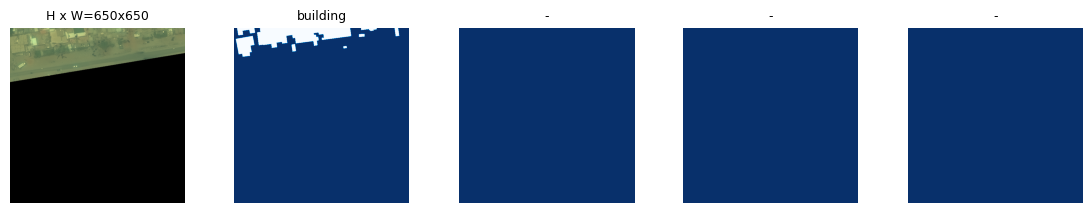

167


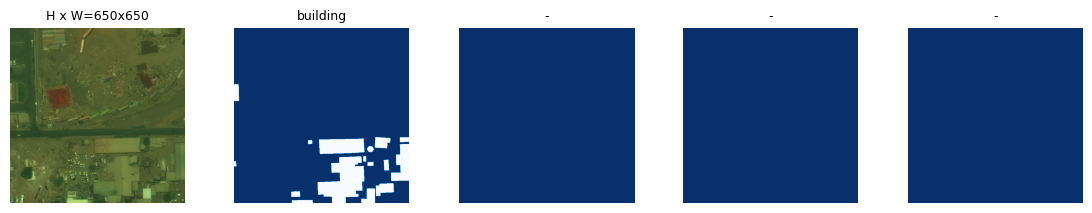

155


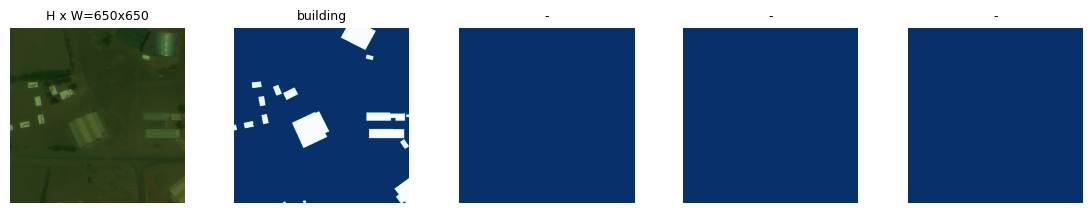

517


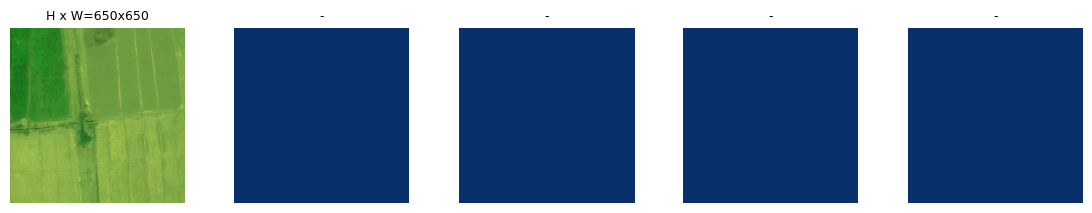

In [65]:
image_ids = np.random.choice(dataset_train.image_ids,4)

for image_id in image_ids:
    print(image_id)
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [52]:
#troubleshooting
# os.path.exists(os.path.join(data_dir, 'images', 'img'+str(500)+'PS-RGB_.png'))
# dataset_train.load_image(500)

# !ls './drive/MyDrive/house_finder/spacenetv2_khartoum/maps/500mask_.png'
# print(os.path.join(data_dir, 'maps', str(500)+'mask_.png'))
# os.path.exists(os.path.join(data_dir, 'maps', str(500)+'mask_.png'))
# dataset_train.load_mask(500)

Create the Model in Training Mode

In [67]:
model = modellib.MaskRCNN(mode = "training", config = config, model_dir = MODEL_DIR)

# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

Training

1. Completed in two stages: Freezing the backbone layers and training only the randomly initialized layers.
1. Fine tune all layers. (not required)

In [ ]:
model.train(dataset_train, dataset_val,
            learning_rate = config.LEARNING_RATE,
            epochs = 200,
            layers = 'heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/drive/MyDrive/house_finder/Mask_RCNN/logs/spacenet20230725T2058/mask_rcnn_spacenet_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistri

In [ ]:
# Model Layers fine tuning
model.train(dataset_train, dataset_val,
            learning_rate = config.LEARNING_RATE / 10,
            epochs = 2,
            layers = 'all')

Save Model Weights

In [ ]:
model_path = os.path.join(MODEL_DIR, 'mask_rcnn_spacenet.h5')
model.keras_model.save_weights(model_path)

Configure Inferences

In [ ]:
class InferenceConfig(SpaceNetConfig):
  GPU_COUNT = 1
  IMAGES_PER_GPU = 1

  inference_config = InferenceConfig()

  model = modellib.MaskRCNN(mode = 'inference',
                            config = inference_config,
                            model_dir = MODEL_DIR)

model_path = os.path.join(MODEL_DIR, 'mask_rcnn_spacenet.h5')

print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)